# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 46kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

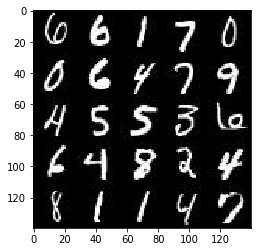

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

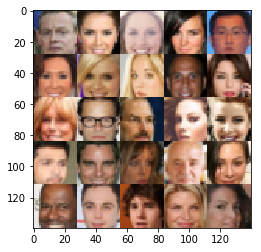

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    orig_shape = images.get_shape().as_list()
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xorig_shape[3]
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        #print(relu1)
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        #print(relu2)
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        #print(relu3)
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        #print(out)
        return out, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True,alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.01 * x1, x1)
        # 3x3x512 now
        #print(x1)
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #out_height = in_height * stride + filter_height -1=3*2+3-1
        # 7x7x256 now
        #print(x2)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        #print(out)
        deal_out = tf.reshape(out,(-1,28,28,out_channel_dim))
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape)

    #sample_z = np.random.uniform(-1, 1, size=(data_shape[-2], z_dim))
    losses = []
    steps = 0
    
    input_real, input_z,learning_rate_1 = model_inputs(data_shape[-3],data_shape[-2],data_shape[-1], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1]) 
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print(batch_z.shape)
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 1, input_z, data_shape[-1], data_image_mode)
        saver.save(sess, './generator.ckpt')
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.3218... Generator Loss: 1.5777
Epoch 0/2... Discriminator Loss: 1.2601... Generator Loss: 4.9030
Epoch 0/2... Discriminator Loss: 1.2637... Generator Loss: 2.8541
Epoch 0/2... Discriminator Loss: 0.8929... Generator Loss: 3.0852
Epoch 0/2... Discriminator Loss: 1.9318... Generator Loss: 4.6510
Epoch 0/2... Discriminator Loss: 1.4894... Generator Loss: 3.0635
Epoch 0/2... Discriminator Loss: 1.6393... Generator Loss: 2.0072
Epoch 0/2... Discriminator Loss: 1.5362... Generator Loss: 2.0064
Epoch 0/2... Discriminator Loss: 1.4625... Generator Loss: 1.6490
Epoch 0/2... Discriminator Loss: 1.3094... Generator Loss: 2.1432


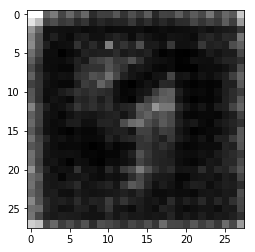

Epoch 0/2... Discriminator Loss: 1.3491... Generator Loss: 2.0924
Epoch 0/2... Discriminator Loss: 0.7504... Generator Loss: 1.4445
Epoch 0/2... Discriminator Loss: 1.3362... Generator Loss: 0.3953
Epoch 0/2... Discriminator Loss: 1.4864... Generator Loss: 0.3219
Epoch 0/2... Discriminator Loss: 1.6939... Generator Loss: 0.2241
Epoch 0/2... Discriminator Loss: 0.5841... Generator Loss: 0.8960
Epoch 0/2... Discriminator Loss: 0.1028... Generator Loss: 3.2615
Epoch 0/2... Discriminator Loss: 0.1048... Generator Loss: 2.6475
Epoch 0/2... Discriminator Loss: 0.0272... Generator Loss: 5.8607
Epoch 0/2... Discriminator Loss: 0.9559... Generator Loss: 0.9940


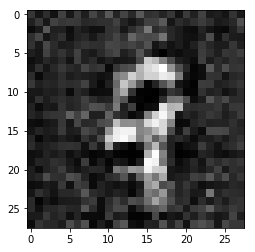

Epoch 0/2... Discriminator Loss: 0.6464... Generator Loss: 1.5765
Epoch 0/2... Discriminator Loss: 1.4477... Generator Loss: 1.9050
Epoch 0/2... Discriminator Loss: 0.7596... Generator Loss: 0.7336
Epoch 0/2... Discriminator Loss: 2.2175... Generator Loss: 0.1384
Epoch 0/2... Discriminator Loss: 1.1492... Generator Loss: 0.5041
Epoch 0/2... Discriminator Loss: 0.9206... Generator Loss: 0.6123
Epoch 0/2... Discriminator Loss: 1.4714... Generator Loss: 0.3019
Epoch 0/2... Discriminator Loss: 3.8318... Generator Loss: 4.6677
Epoch 0/2... Discriminator Loss: 1.5386... Generator Loss: 2.5768
Epoch 0/2... Discriminator Loss: 1.0019... Generator Loss: 2.8286


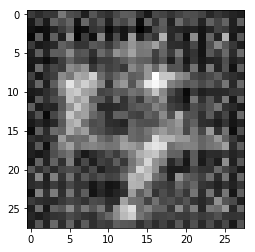

Epoch 0/2... Discriminator Loss: 0.4777... Generator Loss: 1.1689
Epoch 0/2... Discriminator Loss: 0.2565... Generator Loss: 1.7482
Epoch 0/2... Discriminator Loss: 0.0721... Generator Loss: 3.2461
Epoch 0/2... Discriminator Loss: 9.4298... Generator Loss: 9.1097
Epoch 0/2... Discriminator Loss: 0.8013... Generator Loss: 0.7224
Epoch 0/2... Discriminator Loss: 2.4609... Generator Loss: 2.9762
Epoch 0/2... Discriminator Loss: 0.6018... Generator Loss: 0.9763
Epoch 0/2... Discriminator Loss: 0.4774... Generator Loss: 1.1725
Epoch 0/2... Discriminator Loss: 0.1500... Generator Loss: 2.3103
Epoch 0/2... Discriminator Loss: 0.0235... Generator Loss: 6.0564


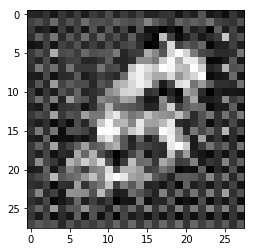

Epoch 0/2... Discriminator Loss: 1.3384... Generator Loss: 3.1300
Epoch 0/2... Discriminator Loss: 0.7134... Generator Loss: 1.3592
Epoch 0/2... Discriminator Loss: 0.8649... Generator Loss: 0.6666
Epoch 0/2... Discriminator Loss: 0.8582... Generator Loss: 2.4787
Epoch 0/2... Discriminator Loss: 0.5227... Generator Loss: 3.3962
Epoch 0/2... Discriminator Loss: 0.4859... Generator Loss: 2.5445
Epoch 1/2... Discriminator Loss: 0.4758... Generator Loss: 3.8880
Epoch 1/2... Discriminator Loss: 0.1115... Generator Loss: 3.1164
Epoch 1/2... Discriminator Loss: 2.3991... Generator Loss: 0.1111
Epoch 1/2... Discriminator Loss: 0.6788... Generator Loss: 0.9200


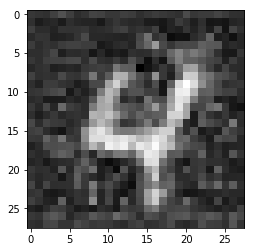

Epoch 1/2... Discriminator Loss: 0.0376... Generator Loss: 4.4977
Epoch 1/2... Discriminator Loss: 3.0567... Generator Loss: 6.3613
Epoch 1/2... Discriminator Loss: 2.0308... Generator Loss: 0.1829
Epoch 1/2... Discriminator Loss: 1.5559... Generator Loss: 0.3048
Epoch 1/2... Discriminator Loss: 1.3991... Generator Loss: 0.3398
Epoch 1/2... Discriminator Loss: 0.8403... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 0.9123... Generator Loss: 0.6342
Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 0.6403
Epoch 1/2... Discriminator Loss: 0.6681... Generator Loss: 0.8863
Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 4.5576


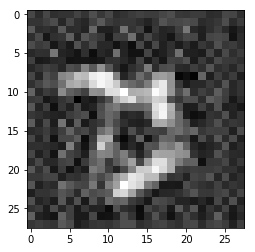

Epoch 1/2... Discriminator Loss: 0.7056... Generator Loss: 3.3943
Epoch 1/2... Discriminator Loss: 0.2354... Generator Loss: 2.1705
Epoch 1/2... Discriminator Loss: 0.5937... Generator Loss: 1.0651
Epoch 1/2... Discriminator Loss: 0.1161... Generator Loss: 2.7853
Epoch 1/2... Discriminator Loss: 0.0623... Generator Loss: 4.0069
Epoch 1/2... Discriminator Loss: 1.4400... Generator Loss: 0.3336
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.3945
Epoch 1/2... Discriminator Loss: 0.7565... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 0.1088... Generator Loss: 3.3028
Epoch 1/2... Discriminator Loss: 0.3162... Generator Loss: 1.6617


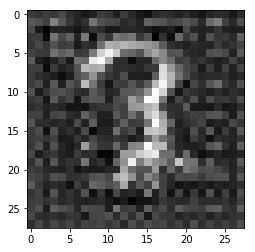

Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 0.6089
Epoch 1/2... Discriminator Loss: 1.2628... Generator Loss: 2.6128
Epoch 1/2... Discriminator Loss: 0.8408... Generator Loss: 3.5804
Epoch 1/2... Discriminator Loss: 0.2265... Generator Loss: 3.0398
Epoch 1/2... Discriminator Loss: 0.1998... Generator Loss: 4.7035
Epoch 1/2... Discriminator Loss: 0.0568... Generator Loss: 5.8746
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.6070
Epoch 1/2... Discriminator Loss: 1.6701... Generator Loss: 0.2632
Epoch 1/2... Discriminator Loss: 1.2941... Generator Loss: 0.3902
Epoch 1/2... Discriminator Loss: 1.4872... Generator Loss: 0.3475


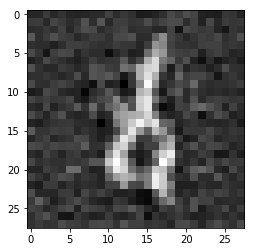

Epoch 1/2... Discriminator Loss: 0.3869... Generator Loss: 1.5588
Epoch 1/2... Discriminator Loss: 0.2262... Generator Loss: 2.1904
Epoch 1/2... Discriminator Loss: 0.0803... Generator Loss: 3.4734
Epoch 1/2... Discriminator Loss: 0.2620... Generator Loss: 1.9292
Epoch 1/2... Discriminator Loss: 0.0581... Generator Loss: 5.4440
Epoch 1/2... Discriminator Loss: 0.0264... Generator Loss: 4.7028
Epoch 1/2... Discriminator Loss: 0.0200... Generator Loss: 4.7470
Epoch 1/2... Discriminator Loss: 0.0835... Generator Loss: 2.9395
Epoch 1/2... Discriminator Loss: 1.7923... Generator Loss: 1.8138
Epoch 1/2... Discriminator Loss: 1.0000... Generator Loss: 2.1480


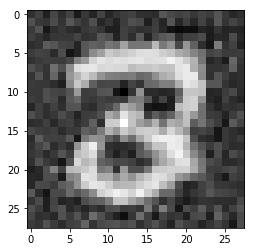

Epoch 1/2... Discriminator Loss: 1.7608... Generator Loss: 2.8450
Epoch 1/2... Discriminator Loss: 0.5469... Generator Loss: 2.3222
Epoch 1/2... Discriminator Loss: 0.4464... Generator Loss: 3.7476


In [29]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.005

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.1879... Generator Loss: 3.6351
Epoch 0/1... Discriminator Loss: 0.1518... Generator Loss: 2.8265
Epoch 0/1... Discriminator Loss: 0.0101... Generator Loss: 7.3569
Epoch 0/1... Discriminator Loss: 1.3854... Generator Loss: 16.5633
Epoch 0/1... Discriminator Loss: 0.7307... Generator Loss: 15.1313
Epoch 0/1... Discriminator Loss: 0.9559... Generator Loss: 1.5745
Epoch 0/1... Discriminator Loss: 0.6985... Generator Loss: 1.7936
Epoch 0/1... Discriminator Loss: 0.5665... Generator Loss: 2.5085
Epoch 0/1... Discriminator Loss: 0.3755... Generator Loss: 1.6644
Epoch 0/1... Discriminator Loss: 0.4158... Generator Loss: 1.3971


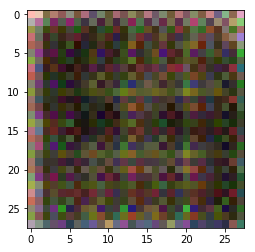

Epoch 0/1... Discriminator Loss: 0.6542... Generator Loss: 5.5718
Epoch 0/1... Discriminator Loss: 0.3422... Generator Loss: 4.0882
Epoch 0/1... Discriminator Loss: 0.2954... Generator Loss: 3.3392
Epoch 0/1... Discriminator Loss: 0.2032... Generator Loss: 6.4006
Epoch 0/1... Discriminator Loss: 0.1060... Generator Loss: 3.9978
Epoch 0/1... Discriminator Loss: 0.0394... Generator Loss: 4.2160
Epoch 0/1... Discriminator Loss: 0.9150... Generator Loss: 6.4435
Epoch 0/1... Discriminator Loss: 1.9997... Generator Loss: 0.2332
Epoch 0/1... Discriminator Loss: 0.4380... Generator Loss: 8.8417
Epoch 0/1... Discriminator Loss: 0.6369... Generator Loss: 0.9651


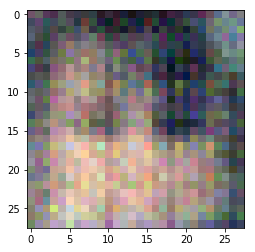

Epoch 0/1... Discriminator Loss: 0.1110... Generator Loss: 4.2612
Epoch 0/1... Discriminator Loss: 2.9139... Generator Loss: 12.2158
Epoch 0/1... Discriminator Loss: 0.5797... Generator Loss: 1.1396
Epoch 0/1... Discriminator Loss: 1.2496... Generator Loss: 0.5325
Epoch 0/1... Discriminator Loss: 0.1395... Generator Loss: 9.4826
Epoch 0/1... Discriminator Loss: 0.6789... Generator Loss: 0.9097
Epoch 0/1... Discriminator Loss: 0.0231... Generator Loss: 10.5505
Epoch 0/1... Discriminator Loss: 0.2174... Generator Loss: 6.1339
Epoch 0/1... Discriminator Loss: 1.5198... Generator Loss: 5.5667
Epoch 0/1... Discriminator Loss: 0.5486... Generator Loss: 1.2371


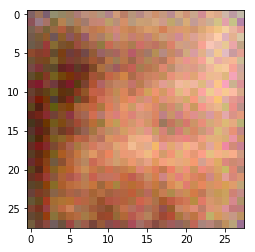

Epoch 0/1... Discriminator Loss: 0.3118... Generator Loss: 1.5693
Epoch 0/1... Discriminator Loss: 0.0211... Generator Loss: 6.9904
Epoch 0/1... Discriminator Loss: 0.0214... Generator Loss: 4.6523
Epoch 0/1... Discriminator Loss: 0.0068... Generator Loss: 15.0494
Epoch 0/1... Discriminator Loss: 0.0049... Generator Loss: 8.5921
Epoch 0/1... Discriminator Loss: 1.0157... Generator Loss: 0.8303
Epoch 0/1... Discriminator Loss: 0.4178... Generator Loss: 3.3793
Epoch 0/1... Discriminator Loss: 0.0077... Generator Loss: 8.5147
Epoch 0/1... Discriminator Loss: 0.5917... Generator Loss: 5.2265
Epoch 0/1... Discriminator Loss: 0.1574... Generator Loss: 2.7802


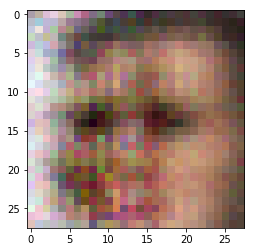

Epoch 0/1... Discriminator Loss: 0.5193... Generator Loss: 1.0309
Epoch 0/1... Discriminator Loss: 0.0654... Generator Loss: 3.1629
Epoch 0/1... Discriminator Loss: 0.1344... Generator Loss: 2.8359
Epoch 0/1... Discriminator Loss: 0.0503... Generator Loss: 5.6858
Epoch 0/1... Discriminator Loss: 0.5528... Generator Loss: 1.6660
Epoch 0/1... Discriminator Loss: 0.2002... Generator Loss: 2.2094
Epoch 0/1... Discriminator Loss: 0.1809... Generator Loss: 4.2528
Epoch 0/1... Discriminator Loss: 0.0890... Generator Loss: 6.6320
Epoch 0/1... Discriminator Loss: 0.7376... Generator Loss: 5.3224
Epoch 0/1... Discriminator Loss: 0.0142... Generator Loss: 7.8450


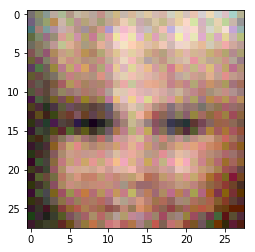

Epoch 0/1... Discriminator Loss: 0.0439... Generator Loss: 5.2347
Epoch 0/1... Discriminator Loss: 0.0078... Generator Loss: 8.2829
Epoch 0/1... Discriminator Loss: 1.3623... Generator Loss: 0.3616
Epoch 0/1... Discriminator Loss: 0.1298... Generator Loss: 8.9644
Epoch 0/1... Discriminator Loss: 1.0147... Generator Loss: 0.5151
Epoch 0/1... Discriminator Loss: 0.1333... Generator Loss: 4.7196
Epoch 0/1... Discriminator Loss: 0.0373... Generator Loss: 7.6291
Epoch 0/1... Discriminator Loss: 0.1985... Generator Loss: 7.0282
Epoch 0/1... Discriminator Loss: 0.1555... Generator Loss: 2.3183
Epoch 0/1... Discriminator Loss: 0.6792... Generator Loss: 0.7982


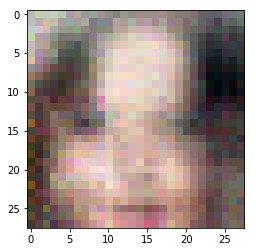

Epoch 0/1... Discriminator Loss: 2.5557... Generator Loss: 0.1079
Epoch 0/1... Discriminator Loss: 0.0424... Generator Loss: 5.2343
Epoch 0/1... Discriminator Loss: 2.1614... Generator Loss: 0.1514
Epoch 0/1... Discriminator Loss: 0.0098... Generator Loss: 7.5876
Epoch 0/1... Discriminator Loss: 0.0525... Generator Loss: 10.1303
Epoch 0/1... Discriminator Loss: 0.0738... Generator Loss: 11.2577
Epoch 0/1... Discriminator Loss: 0.0110... Generator Loss: 6.0748
Epoch 0/1... Discriminator Loss: 0.0296... Generator Loss: 8.1929
Epoch 0/1... Discriminator Loss: 0.0675... Generator Loss: 10.9999
Epoch 0/1... Discriminator Loss: 0.0238... Generator Loss: 4.5936


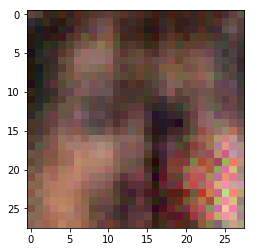

Epoch 0/1... Discriminator Loss: 0.0100... Generator Loss: 6.0325
Epoch 0/1... Discriminator Loss: 0.0168... Generator Loss: 8.7158
Epoch 0/1... Discriminator Loss: 0.0489... Generator Loss: 8.8593
Epoch 0/1... Discriminator Loss: 0.1901... Generator Loss: 2.0362
Epoch 0/1... Discriminator Loss: 0.0230... Generator Loss: 4.7813
Epoch 0/1... Discriminator Loss: 0.0294... Generator Loss: 4.2051
Epoch 0/1... Discriminator Loss: 0.0243... Generator Loss: 4.7341
Epoch 0/1... Discriminator Loss: 0.0266... Generator Loss: 4.7108
Epoch 0/1... Discriminator Loss: 0.0095... Generator Loss: 7.7456
Epoch 0/1... Discriminator Loss: 0.0043... Generator Loss: 8.7888


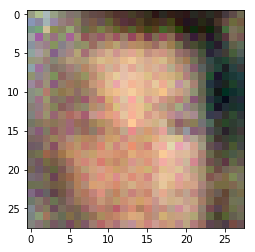

Epoch 0/1... Discriminator Loss: 0.0162... Generator Loss: 5.0778
Epoch 0/1... Discriminator Loss: 0.1401... Generator Loss: 2.3722
Epoch 0/1... Discriminator Loss: 0.4694... Generator Loss: 1.3830
Epoch 0/1... Discriminator Loss: 0.6197... Generator Loss: 1.0807
Epoch 0/1... Discriminator Loss: 0.5954... Generator Loss: 3.6822
Epoch 0/1... Discriminator Loss: 0.2868... Generator Loss: 3.8318
Epoch 0/1... Discriminator Loss: 0.0230... Generator Loss: 5.4785
Epoch 0/1... Discriminator Loss: 0.2724... Generator Loss: 1.8037
Epoch 0/1... Discriminator Loss: 0.2792... Generator Loss: 14.6419
Epoch 0/1... Discriminator Loss: 0.7310... Generator Loss: 5.7390


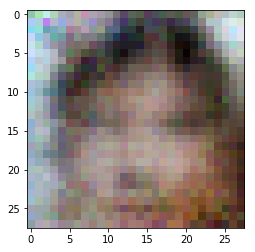

Epoch 0/1... Discriminator Loss: 0.4260... Generator Loss: 1.2934
Epoch 0/1... Discriminator Loss: 2.0924... Generator Loss: 1.4100
Epoch 0/1... Discriminator Loss: 1.0223... Generator Loss: 1.3502
Epoch 0/1... Discriminator Loss: 0.9343... Generator Loss: 1.1569
Epoch 0/1... Discriminator Loss: 0.1235... Generator Loss: 2.7600
Epoch 0/1... Discriminator Loss: 0.0734... Generator Loss: 5.1639
Epoch 0/1... Discriminator Loss: 0.1843... Generator Loss: 5.7251
Epoch 0/1... Discriminator Loss: 0.0880... Generator Loss: 3.8630
Epoch 0/1... Discriminator Loss: 2.8625... Generator Loss: 0.1121
Epoch 0/1... Discriminator Loss: 0.1037... Generator Loss: 5.3183


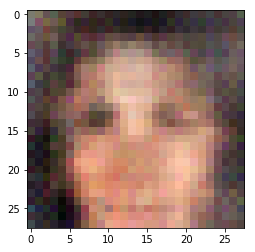

Epoch 0/1... Discriminator Loss: 4.0110... Generator Loss: 0.0309
Epoch 0/1... Discriminator Loss: 0.0886... Generator Loss: 3.0684
Epoch 0/1... Discriminator Loss: 0.6337... Generator Loss: 2.2012
Epoch 0/1... Discriminator Loss: 0.4455... Generator Loss: 1.8830
Epoch 0/1... Discriminator Loss: 0.0862... Generator Loss: 5.3429
Epoch 0/1... Discriminator Loss: 0.7188... Generator Loss: 0.9252
Epoch 0/1... Discriminator Loss: 0.6729... Generator Loss: 0.9973
Epoch 0/1... Discriminator Loss: 0.2479... Generator Loss: 3.0880
Epoch 0/1... Discriminator Loss: 0.5010... Generator Loss: 1.3432
Epoch 0/1... Discriminator Loss: 0.6996... Generator Loss: 10.0332


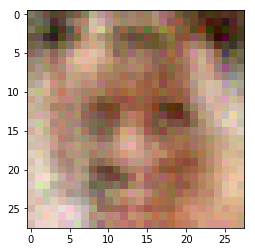

Epoch 0/1... Discriminator Loss: 0.7765... Generator Loss: 0.9109
Epoch 0/1... Discriminator Loss: 1.7221... Generator Loss: 0.2871
Epoch 0/1... Discriminator Loss: 0.3366... Generator Loss: 1.8584
Epoch 0/1... Discriminator Loss: 0.9562... Generator Loss: 1.8180
Epoch 0/1... Discriminator Loss: 1.5169... Generator Loss: 0.3925
Epoch 0/1... Discriminator Loss: 0.1154... Generator Loss: 3.6400
Epoch 0/1... Discriminator Loss: 2.5951... Generator Loss: 0.1177
Epoch 0/1... Discriminator Loss: 2.1579... Generator Loss: 0.1981
Epoch 0/1... Discriminator Loss: 0.6536... Generator Loss: 1.0341
Epoch 0/1... Discriminator Loss: 0.0845... Generator Loss: 4.3444


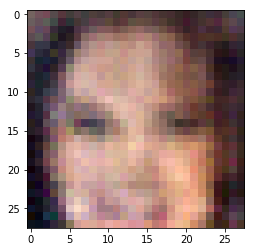

Epoch 0/1... Discriminator Loss: 0.9622... Generator Loss: 3.1935
Epoch 0/1... Discriminator Loss: 0.8780... Generator Loss: 0.8475
Epoch 0/1... Discriminator Loss: 0.1902... Generator Loss: 2.9511
Epoch 0/1... Discriminator Loss: 0.4889... Generator Loss: 1.8807
Epoch 0/1... Discriminator Loss: 0.2672... Generator Loss: 8.1481
Epoch 0/1... Discriminator Loss: 0.4066... Generator Loss: 1.6999
Epoch 0/1... Discriminator Loss: 1.1740... Generator Loss: 0.5956
Epoch 0/1... Discriminator Loss: 0.4454... Generator Loss: 1.6556
Epoch 0/1... Discriminator Loss: 0.3812... Generator Loss: 1.6973
Epoch 0/1... Discriminator Loss: 1.3860... Generator Loss: 0.4713


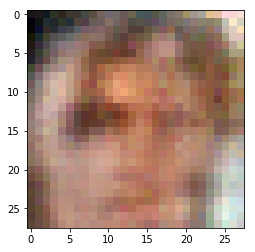

Epoch 0/1... Discriminator Loss: 1.0935... Generator Loss: 2.8805
Epoch 0/1... Discriminator Loss: 0.8322... Generator Loss: 0.8942
Epoch 0/1... Discriminator Loss: 0.0583... Generator Loss: 5.8252
Epoch 0/1... Discriminator Loss: 1.0320... Generator Loss: 0.8399
Epoch 0/1... Discriminator Loss: 0.5360... Generator Loss: 1.7606
Epoch 0/1... Discriminator Loss: 0.4396... Generator Loss: 1.7991
Epoch 0/1... Discriminator Loss: 1.1162... Generator Loss: 0.7714
Epoch 0/1... Discriminator Loss: 3.2332... Generator Loss: 7.7617
Epoch 0/1... Discriminator Loss: 0.7913... Generator Loss: 1.1612
Epoch 0/1... Discriminator Loss: 0.6743... Generator Loss: 1.2860


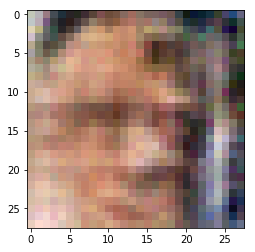

Epoch 0/1... Discriminator Loss: 0.4932... Generator Loss: 2.6306
Epoch 0/1... Discriminator Loss: 0.6548... Generator Loss: 1.4303
Epoch 0/1... Discriminator Loss: 0.6720... Generator Loss: 1.6198
Epoch 0/1... Discriminator Loss: 0.1950... Generator Loss: 3.9199
Epoch 0/1... Discriminator Loss: 0.7052... Generator Loss: 1.4350
Epoch 0/1... Discriminator Loss: 3.2248... Generator Loss: 6.3350
Epoch 0/1... Discriminator Loss: 0.6008... Generator Loss: 1.4348
Epoch 0/1... Discriminator Loss: 0.5629... Generator Loss: 1.6516
Epoch 0/1... Discriminator Loss: 0.3100... Generator Loss: 3.0498
Epoch 0/1... Discriminator Loss: 0.7165... Generator Loss: 2.1151


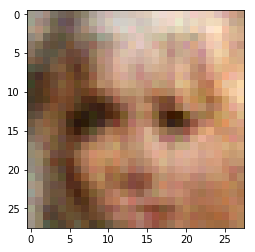

Epoch 0/1... Discriminator Loss: 0.5271... Generator Loss: 2.2497
Epoch 0/1... Discriminator Loss: 0.5279... Generator Loss: 1.8040
Epoch 0/1... Discriminator Loss: 0.1273... Generator Loss: 7.2246
Epoch 0/1... Discriminator Loss: 1.1423... Generator Loss: 0.7091
Epoch 0/1... Discriminator Loss: 0.5071... Generator Loss: 1.9061
Epoch 0/1... Discriminator Loss: 0.7510... Generator Loss: 1.3170
Epoch 0/1... Discriminator Loss: 0.9909... Generator Loss: 0.6964
Epoch 0/1... Discriminator Loss: 0.6247... Generator Loss: 1.5064


In [33]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.